# Fit BAO peak from input correlation function

In [1]:
import numpy as np
import time

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.bao_model import *
from densitysplit.split_fit import *
from densitysplit.utils import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

## Load correlation function multipoles

### Real or redshift space

In [5]:
rsd = True

if rsd:
    ells = [0, 2]
    f = bg.growth_rate(z)
    sigma_s = 4.
else:
    ells = [0]
    f = 0.
    sigma_s = 0.

### 2PCF

In [6]:
nells = len(ells)
nsplits = 1
nmocks = 5000

if rsd:
    abacus_result = TwoPointCorrelationFunction.load(output_dir+catalog.name+'_2PCF_RSD.npy')
    mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_5000_mocks_2PCF_RSD_all.npy', allow_pickle=True)
else:
    abacus_result = TwoPointCorrelationFunction.load(output_dir+catalog.name+'_2PCF.npy')
    mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_2PCF.npy', allow_pickle=True)    

_, cov = get_poles(mocks_results, ells)

s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)

[000000.26]  06-22 17:46  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z1.175_2PCF_RSD.npy.


In [7]:
cov /= 8.

In [8]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
cov *= hartlap

## Set power spectrum model

In [9]:
bao_model = BAOModel(sep=s, k=np.logspace(-3,2,1000), ells=ells, redshift=z, cosmology=cosmo_abacus, iso=(not rsd), nsplits=nsplits)

bao_model.set_params(f_DS1=f, b_DS1=1.87, sigma_s=sigma_s)

In [10]:
bao_model.model_params

{'sigma_s': 4.0,
 'alpha_iso': 1.0,
 'F': 1.0,
 'sigma_par': 8.0,
 'sigma_perp': 3.0,
 'f_DS1': array(0.89781353),
 'b_DS1': 1.87,
 'bb0_0_DS1': 0,
 'bb1_0_DS1': 0,
 'bb2_0_DS1': 0,
 'bb0_1_DS1': 0,
 'bb1_1_DS1': 0,
 'bb2_1_DS1': 0}

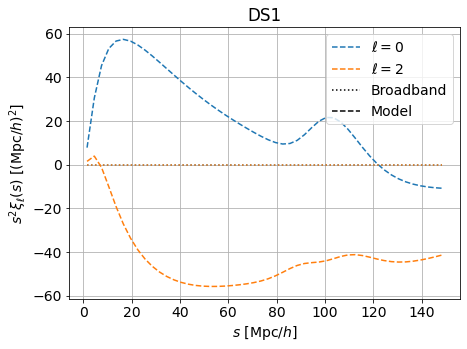

In [11]:
fig, axes = plt.subplots(1, nsplits, figsize=(7, 5), sharey = False)

bao_model.plot_split_model(fig=fig, axes=axes, show_broadband=True)

In [12]:
ds_fit = DensitySplitFit(sep=s, k=np.logspace(-3,2,1000), ells=ells, xiell=xiell, cov=cov, 
                         xi_model=bao_model, model_params=bao_model.model_params, model_params_labels=bao_model.model_params_labels, 
                         nsplits=nsplits)

In [13]:
broadband_coeffs = np.tile([0., 0., 0.], nells)

if rsd:
    params_init = {'alpha_iso': 1., 'F': 1., 'sigma_par': 8., 'sigma_perp': 3.}
else:
    params_init = {'b_DS1': 2, 'alpha_iso': 1., 'sigma_iso': 5.}

#for split in range(bao_model.nsplits):
#    for ill in range(bao_model.nells):
#        for k in range(3):
#            params_init.update({'bb{}_{}_DS{}'.format(k, ill, split+1): 0})

t1 = time.time()
ds_fit.fit(fit_params_init=params_init, s_lower_limit=50, fit_method='scipy')
t2 = time.time()
print('Execution time: ', t2-t1)

Optimal parameters:
{'alpha_iso': 0.9993239487989456, 'F': 0.9809613328436738, 'sigma_par': 7.124404642325194, 'sigma_perp': 6.1519613613565065}

Covariance matrix:
[[ 1.51681535e-05  7.74905147e-06  9.96730668e-05  2.23437226e-05]
 [ 7.74905147e-06  2.64290082e-04  4.74039053e-03 -2.15781896e-03]
 [ 9.96730668e-05  4.74039053e-03  1.38955863e+00 -3.64009032e-01]
 [ 2.23437226e-05 -2.15781896e-03 -3.64009032e-01  4.68375591e-01]]

Sigmas:
[0.00389463 0.016257   1.17879542 0.68437971]
Execution time:  0.7386891841888428


[000005.23]  06-22 17:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000005.23]  06-22 17:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000005.35]  06-22 17:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000005.35]  06-22 17:46  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


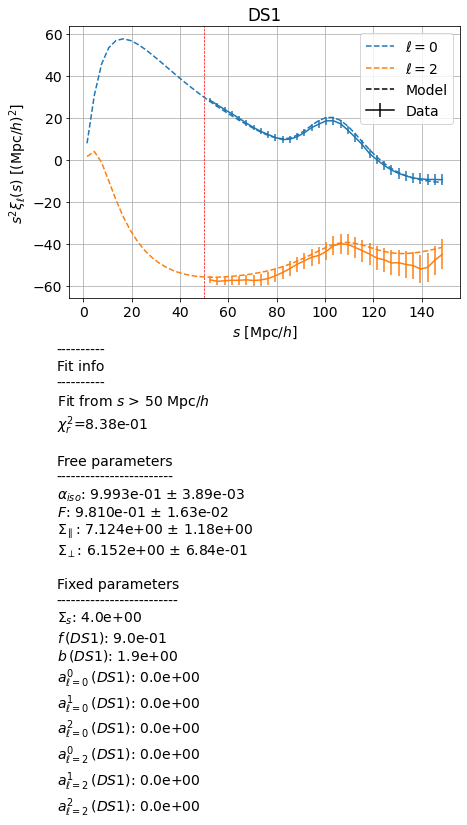

In [14]:
fig, axes = plt.subplots(1, nsplits, figsize=(7, 5), sharey = False)

ds_fit.plot_split_model(fig=fig, axes=axes, show_broadband=False, show_info=True)

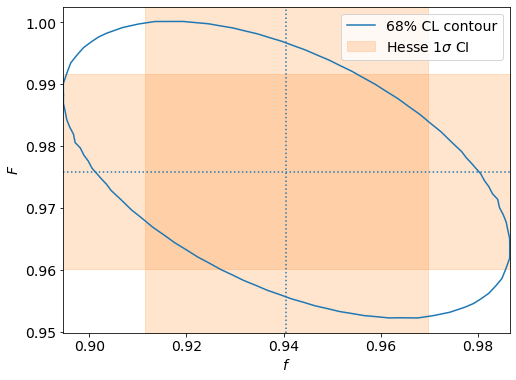

In [15]:
if rsd:
    ds_fit.draw_contour(params=['f', 'F'], free_params_init=params_init)
    
else:
    ds_fit.draw_profile(param='alpha_iso', free_params_init=params_init)
    plt.show()
    ds_fit.draw_profile(param='sigma_iso', free_params_init=params_init)
    plt.show()

In [16]:
np.save(output_dir+catalog_name+'_2PCF_F_f_contour_f_b_free', ds_fit.mncontour)

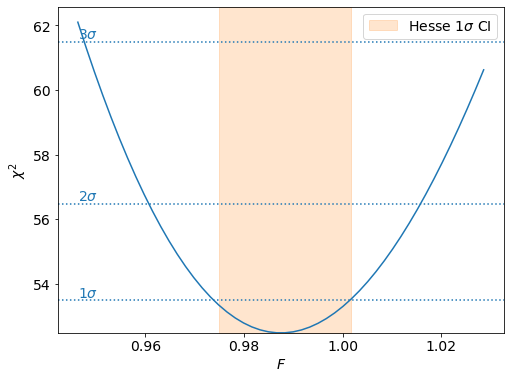

In [19]:
ds_fit.draw_profile(param='F', free_params_init=params_init)

In [20]:
np.save(output_dir+catalog_name+'_2PCF_F_profile_f_b_fixed', ds_fit.mnprofile)

In [ ]:
alpha_par = [x[0] for x in ds_fit.mncontour]
alpha_par.append(alpha_par[0])
alpha_perp = [x[1] for x in ds_fit.mncontour]
alpha_perp.append(alpha_perp[0])

In [ ]:
x = np.linspace(np.min(alpha_par), np.max(alpha_par), 50)
a = [min_location[1]-hesse_errors[1] for i in x]
b = [min_location[1]+hesse_errors[1] for i in x]

In [ ]:
min_location = [ds_fit.popt_dict['alpha_par'], ds_fit.popt_dict['alpha_perp']]
hesse_errors = [ds_fit.pstd_dict['alpha_par'], ds_fit.pstd_dict['alpha_perp']]
plt.plot(alpha_par, alpha_perp, label='68% CL contour')
ylim = plt.gca().get_ylim()
plt.margins(0, 0)
plt.fill_between(x, ylim[0], ylim[1], where=np.logical_and(x>=(min_location[0]-hesse_errors[0]), x<=(min_location[0]+hesse_errors[0])), color='C1', alpha=0.2, label=r'Hesse 1$\sigma$ CI')
plt.fill_between(x, a, b, color='C1', alpha=0.2)
plt.axvline(min_location[0], linestyle=':')
plt.axhline(min_location[1], linestyle=':')
plt.xlabel(r'$\alpha_{\parallel}$')
plt.ylabel(r'$\alpha_{\perp}$')
plt.legend()